In [866]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import tensorflow as tf
import h5py, os, yaml
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re
import seaborn as sns
from scipy import stats
# !pip install https://github.com/p-koo/tfomics/tarball/master
import tfomics
from test_to_bw_fast import read_model, get_config
import pandas as pd
import matplotlib.patches as patches
from tensorflow import keras
import plotly.express as px
import tfr_evaluate, util
import subprocess
import explain
from scipy.stats import pearsonr
from tqdm import tqdm
import glob
import embed
import control_shuffle as dn
from scipy.stats import pearsonr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1188]:
def onehot_to_str(onehot):
    full_str = []
    for one_onehot in onehot:
        assert one_onehot.shape == (4,)
        full_str.append(list('ACGT')[np.argwhere(one_onehot)[0][0]])
    return ''.join(full_str)

def find_motif(motif_pattern_list, str_seq):
#     motif_pattern = "TGA.TCA" #'GGG.G.GGT'
    motif_tuples = []
    for motif_pattern in motif_pattern_list:
        iter = re.finditer(motif_pattern, str_seq)
        indices = [m.start(0) for m in iter]
        if len(indices)>0:
            chosen_ind = indices[np.abs(indices-max_point).argmin()]
        else:
            chosen_ind = None
        motif_tuples.append((chosen_ind, motif_pattern))
    return motif_tuples
        

def remove_motif_from_seq(motif_tuples, selected_seq):
    all_patterns = ''
#     
    for motif_start, motif_pattern in motif_tuples:
        motif_end = motif_start+len(motif_pattern)
        motif_chunk = selected_seq[motif_start:motif_end]
        empty_pattern = np.zeros_like(motif_chunk)+0.25
        selected_seq[motif_start:motif_end] = empty_pattern
        all_patterns += (motif_pattern+', ')
    all_patterns = all_patterns.rstrip(', ')
    return selected_seq, all_patterns 

In [756]:
def get_GC_content(seq_array):
    return 2*seq_array[:,:,1].sum(axis=-1)/seq_array.shape[1]

def plot_mean_coverages(data_and_labels, ax):
    for i, (data, label, p) in enumerate(data_and_labels):
        if 'non' in label:
            marker_style = '--'
        else:
            marker_style = '-'
        x = np.arange(data.shape[1])
        est = np.mean(data, axis=0)
        sd = np.std(data, axis=0)
        cis = (est - sd, est + sd)
        ax.fill_between(x,cis[0], cis[1], alpha=0.08, color=p)
        ax.plot(x,  est,p,label=label)

In [91]:
def plot_true_pred(idx, idx_name, cell_line=13):
    fig, axs = plt.subplots(1,2, figsize=[15,5])
    axs[0].plot(filtered_Y[idx,:,cell_line].T);
    axs[1].plot(np.repeat(preds[idx,:,cell_line], 32, axis=1).T);
    pr = []
    for i in idx:
        pr.append(pearsonr(filtered_Y[i,:,cell_line], np.repeat(preds[i,:,cell_line], 32))[0])
    pr = np.round(np.mean(pr),3)

    plt.suptitle('{} points, mean per seq pearson r = {}'.format(idx_name, pr));

In [904]:
# load and threshold data
testset, targets = tfr_evaluate.collect_whole_testset(coords=True)
threshold = 2
cell_line = 13
thresholded_C, thresholded_X, thresholded_Y = embed.threshold_cell_line_testset(testset, cell_line)
idr_class = embed.label_idr_peaks(thresholded_C, cell_line)

thresholded_Y.shape

(23346, 2048)

In [1107]:
low_coords, low_seqs, low_cov = embed.threshold_cell_line_testset(testset, cell_line, 0.5, less_than=2)

In [1077]:
low_pred = embed.predict_np(low_seqs, model, batch_size=32, reshape_to_2D=False)

In [24]:
# load and get model layer
run_path = '../'+'paper_runs/new_models/32_res/run-20211023_095131-w6okxt01'
layer = -3
model, bin_size = read_model(run_path, compile_model=False)
aux_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)
    

In [163]:
# get int repr embeddings and predictions
interm_representations = embed.predict_np(thresholded_X, aux_model, batch_size=32, reshape_to_2D=True)
embeddings = embed.get_embeddings(interm_representations)
embeddings['IDR'] = idr_class
embeddings['cell line'] = targets[cell_line]
predictions = embed.predict_np(thresholded_X, model, batch_size=32, reshape_to_2D=False)

In [989]:

# plt.hist(GC_content_all)

0.326171875

No handles with labels found to put in legend.


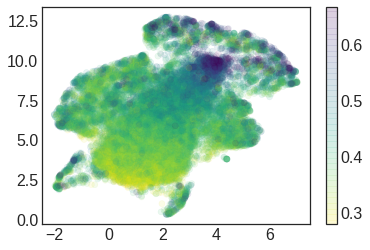

In [993]:
GC_content_all = get_GC_content(thresholded_X)
embeddings['GC content'] = GC_content_all

plt.scatter(x=embeddings['UMAP 1'], 
                y=embeddings['UMAP 2'],
                alpha=0.1,
                c=embeddings['GC content'],
               cmap='viridis_r')
plt.clim(np.percentile(GC_content_all, 1),np.percentile(GC_content_all, 99))
c = plt.colorbar()
plt.legend(bbox_to_anchor=(1,1));

In [672]:
# slice different parts of the seamonster
colorblind_pallete = ["#000000","#004949","#009292","#ff6db6","#ffb6db",
                     "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
                     "#920000","#924900","#db6d00","#24ff24","#ffff6d"]
conditions = [((embeddings['UMAP 1']<-1)&(embeddings['UMAP 2']>5)&(embeddings['IDR']==True), 'left IDR', '#0542F3'),
                 ((embeddings['UMAP 1']>4)&(embeddings['UMAP 2']<6)&(embeddings['IDR']==True),'top IDR', colorblind_pallete[5]),
                 ((embeddings['UMAP 1']>3)&(embeddings['UMAP 2']>10)&(embeddings['IDR']==True), 'right IDR', colorblind_pallete[2]),
                 ((embeddings['UMAP 1']<-1)&(embeddings['UMAP 2']>5)&(embeddings['IDR']!=True), 'left non-IDR', '#05B9F3'),
                 ((embeddings['UMAP 1']>4)&(embeddings['UMAP 2']<6)&(embeddings['IDR']!=True), 'top non-IDR', colorblind_pallete[7]),
                 ((embeddings['UMAP 1']>3)&(embeddings['UMAP 2']>10)&(embeddings['IDR']!=True), 'right non-IDR', colorblind_pallete[13])]


conditions.append((((embeddings['UMAP 1']>0.5)&
     (embeddings['UMAP 1']<4.8)&
     (embeddings['UMAP 2']>5)&
     (embeddings['UMAP 2']<8)&
     (embeddings['UMAP 2']>7.8)&  
     (embeddings['IDR']!=True)), 'center non-IDR', colorblind_pallete[11]))

conditions.append((((embeddings['UMAP 1']>0.5)&
                     (embeddings['UMAP 1']<3.5)&
                     (embeddings['UMAP 2']>5)&
                     (embeddings['UMAP 2']<8)&
                     (embeddings['IDR']==True)),'center IDR', colorblind_pallete[10]))

In [674]:
# add splice labels
labels = np.array(['IDR' if e else 'non-IDR' for e in embeddings['IDR'].values])
labels = labels.astype('U25')
color_correspondance = {'non-IDR':'#B2BABB', 
                        'IDR':'#FF5733'}
for c, l, p in conditions:
    print(l)
    labels[c] = l
    color_correspondance[l] = p
embeddings['labels'] = labels

left IDR
top IDR
right IDR
left non-IDR
top non-IDR
right non-IDR
center non-IDR
center IDR


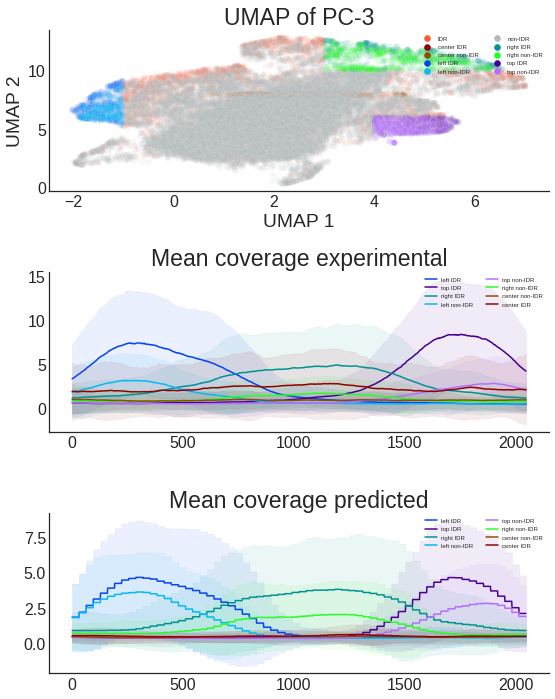

In [1169]:
# plot seamosnter with slices and avg coverage
font = {'size': 16}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(3,1,figsize=[8,10])

sns.scatterplot(data=embeddings.sort_values('labels'),
               x='UMAP 1', y='UMAP 2',
               hue='labels', alpha=0.1, 
               palette=color_correspondance,
               ax=axs[0])

plt.style.use('seaborn-white')

data_and_labels = [(thresholded_Y[c],l,p) for c, l, p in conditions]
plot_mean_coverages(data_and_labels, axs[1])

data_and_labels = [(np.repeat(predictions[:,:,cell_line][c], bin_size, axis=1),l,p) for c, l, p in conditions]
plot_mean_coverages(data_and_labels, axs[2])
for i, title in enumerate(['UMAP of PC-3', "Mean coverage experimental", 'Mean coverage predicted']):    
#     axs[i].set_ylim(0, ax.get_ylim()[1]+2)
    axs[i].legend(loc='upper right', bbox_to_anchor=(1,1), 
                  ncol=2, prop={'size': 6})
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_title(title)

plt.tight_layout()

# GIA - shuffle sequences

In [695]:
# select sequences
# N = 10000
# top_N = np.argpartition(thresholded_Y.max(axis=1), -N)[-N:]
top_n = thresholded_Y.shape[0]
included_indx = []
# for each sequence decide if good enough
for i in top_N:
    pr = pearsonr(thresholded_Y[i].reshape(2048//bin_size, bin_size).mean(axis=-1), predictions[i,:,cell_line])[0]
    if (thresholded_Y[i]>2).any() and (predictions[i,:,cell_line]>2).any() and pr>0.8:
#     if (thresholded_Y[i]<5).all() and (predictions[i,:,cell_line]<5).all():
        included_indx.append(i)

In [698]:
# get original sequence preds
ori_pred = predictions[included_indx,:,cell_line]
ori_pred_max = ori_pred.max(axis=1)
# get shuffled sequence preds
shuffled_pred = []
shuffled_pred_max = []
shuffled_seqs = []
for seq_i in included_indx:
#     shuffled_seq = np.expand_dims(dinuc_shuffle(thresholded_X[seq_i,:,:]), axis=0)
    shuffled_seq = np.expand_dims(np.random.permutation(thresholded_X[seq_i,:,:]), axis=0)
    shuffled_seqs.append(shuffled_seq)
    shuffled_pred.append(model(shuffled_seq)[0,:,cell_line])
    shuffled_pred_max.append(shuffled_pred[-1].numpy().max())


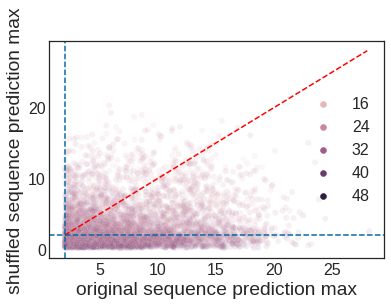

In [752]:
# compare original and shuffled preds
sns.scatterplot(x=ori_pred_max, y=shuffled_pred_max, 
            alpha=0.1, 
            hue=thresholded_X[included_indx,:,0].sum(axis=-1)/thresholded_X.shape[1]*100)
plt.xlabel('original sequence prediction max')
plt.ylabel('shuffled sequence prediction max')
x=np.arange(ori_pred_max.min(),ori_pred_max.max())
plt.plot(x,x, 'r--')
cutoff = 2
plt.axhline(cutoff, linestyle='--')
plt.axvline(cutoff, linestyle='--')


Text(0.5, 1.0, 'GC content')

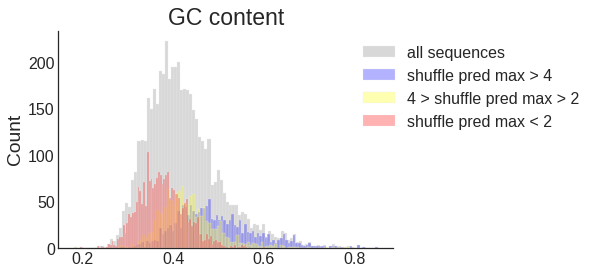

In [791]:
# compare GC contents
gc = get_GC_content(thresholded_X[included_indx])
sns.histplot(gc, bins=100, label='all sequences', 
             alpha=0.3, color='grey'
            );

gc = get_GC_content(thresholded_X[included_indx][np.array(shuffled_pred_max)>4])
sns.histplot(gc, bins=100, 
             label='shuffle pred max > 4', 
             alpha=0.3, color='blue');

gc = get_GC_content(thresholded_X[included_indx][(np.array(shuffled_pred_max)<4)&(np.array(shuffled_pred_max)>2)])
sns.histplot(gc, bins=100, 
             label='4 > shuffle pred max > 2', 
             alpha=0.3, color='yellow');

gc = get_GC_content(thresholded_X[included_indx][np.array(shuffled_pred_max)<2])
sns.histplot(gc, bins=100, 
             label='shuffle pred max < 2',
             alpha=0.3, color='red');


plt.legend(loc='upper right', bbox_to_anchor=(1.6,1))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('GC content')

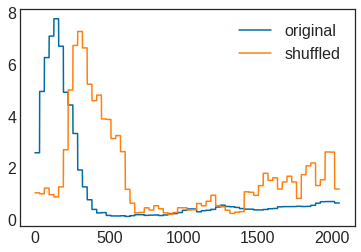

In [703]:
i = 10
above_line = np.argwhere((np.array(shuffled_pred_max)>cutoff))
#                         (np.array(ori_pred_max)<cutoff+1))
np_shuffled = np.squeeze(np.array(shuffled_pred)[above_line[i]])
np_ori = np.squeeze(np.array(ori_pred)[above_line[i]])
np_X = thresholded_X
plt.plot(np.repeat(np_ori, bin_size), label='original');
plt.plot(np.repeat(np_shuffled, bin_size), label='shuffled');
plt.legend()
# plot saliency maps
X_sample = thresholded_X[included_indx][above_line[i]]
saliency_scores = explainer.saliency_maps(X_sample)
# plot attribution maps in a narrow range about max saliency value
explain.plot_saliency_logos(saliency_scores, X_sample, window=200)
plt.title('original sequence')

X_sample = np.squeeze(np.array(shuffled_seqs))[above_line[i]]
saliency_scores = explainer.saliency_maps(X_sample)
# plot attribution maps in a narrow range about max saliency value
explain.plot_saliency_logos(saliency_scores, X_sample, window=200)
plt.title('shuffled sequence')

# GIA - remove motifs, do peaks dissapear?
Match GC content for peak & no peak, take peak motif, put in no peak, does a peak appear?

In [1199]:
# select sequences
N = 100
top_N = np.argpartition(thresholded_Y.max(axis=1), -N)[-N:]
# top_n = thresholded_Y.shape[0]
included_indx = []
# for each sequence decide if good enough
for i in top_N:
    pr = pearsonr(thresholded_Y[i].reshape(2048//bin_size, bin_size).mean(axis=-1), predictions[i,:,cell_line])[0]
    pos, _ = find_motif(['TGA.TCA'], onehot_to_str(thresholded_X[i]))[0]
    if (thresholded_Y[i]>5).any() and (predictions[i,:,cell_line]>5).any() and pr>0.8: #and pos:
#     if (thresholded_Y[i]<5).all() and (predictions[i,:,cell_line]<5).all():
        included_indx.append(i)

In [1200]:
len(included_indx)

69

../explain.py:942: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1,figsize=[20, 2])


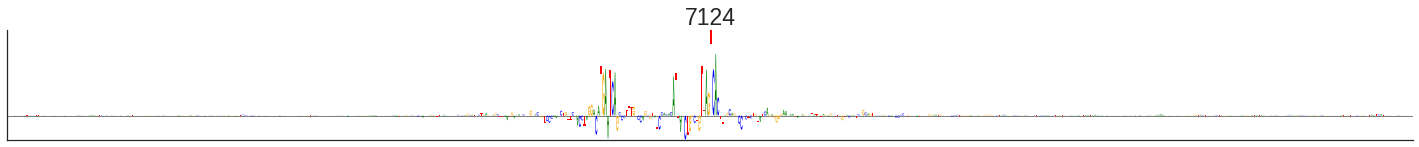

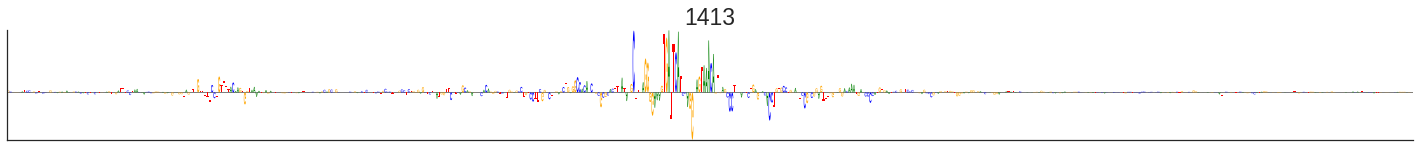

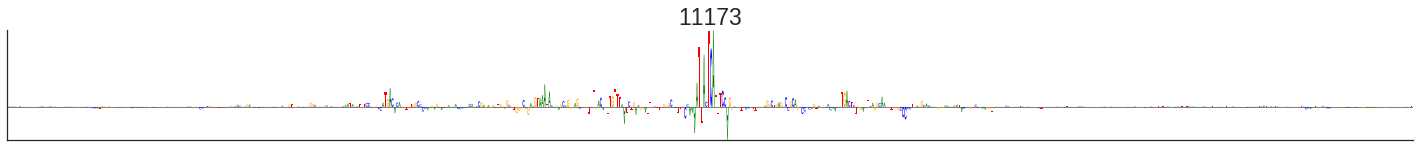

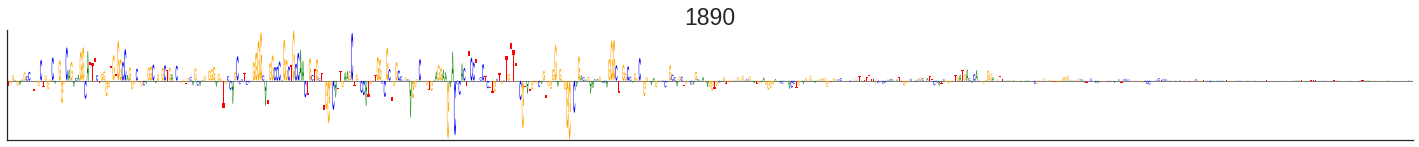

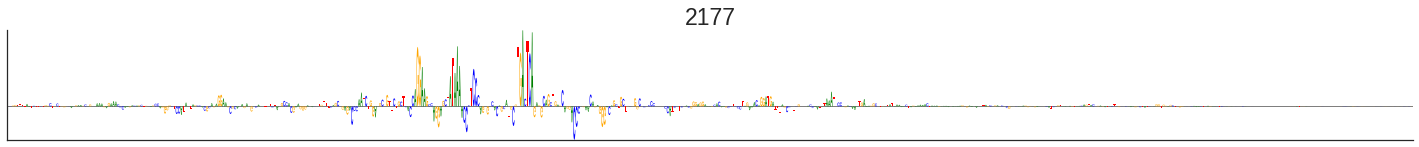

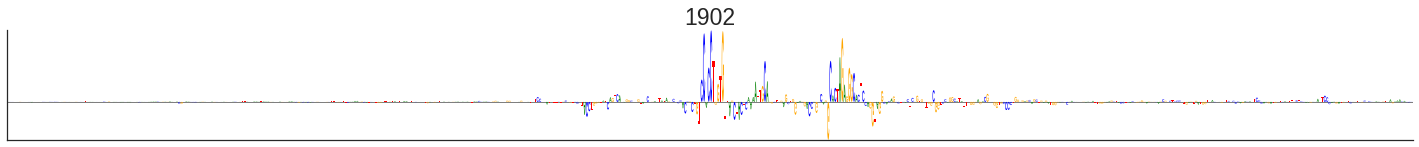

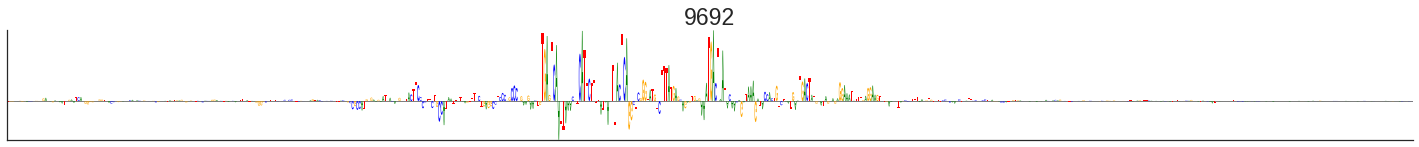

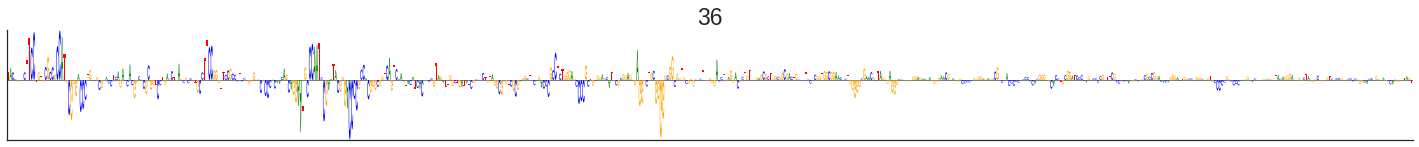

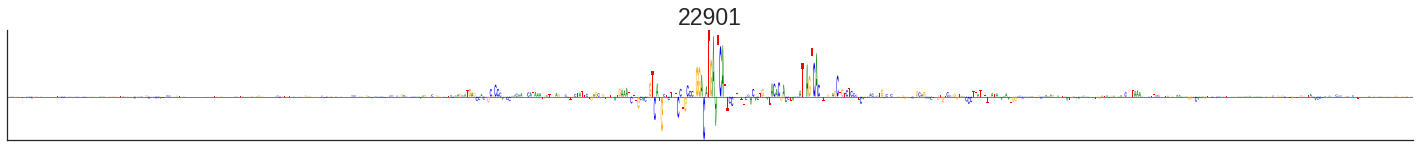

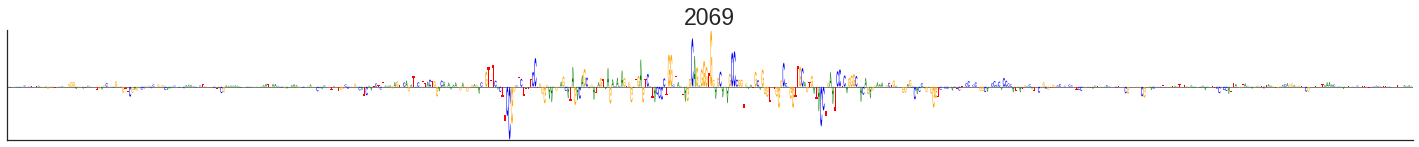

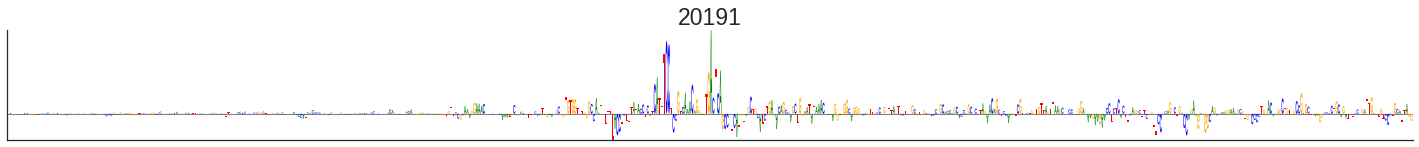

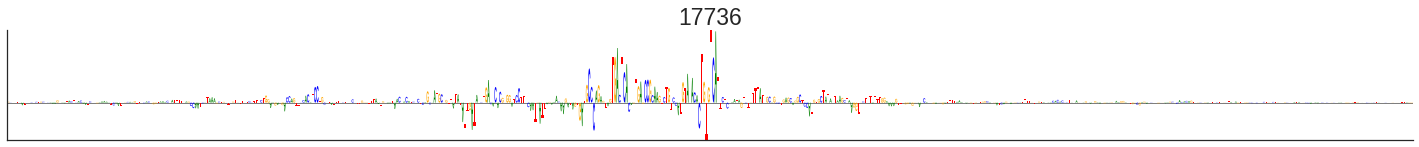

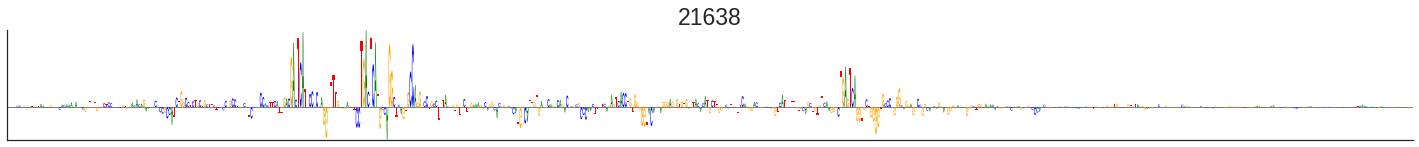

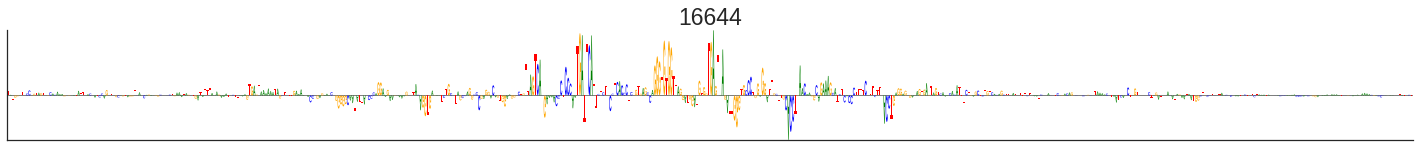

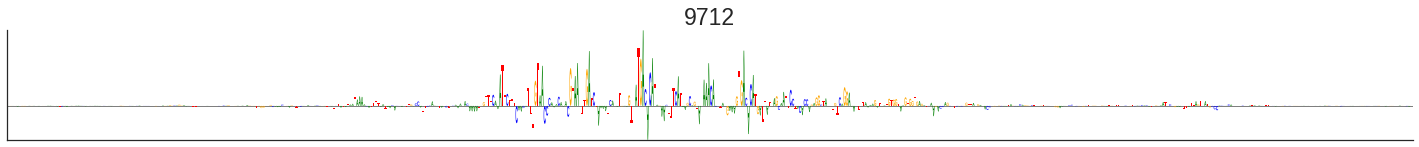

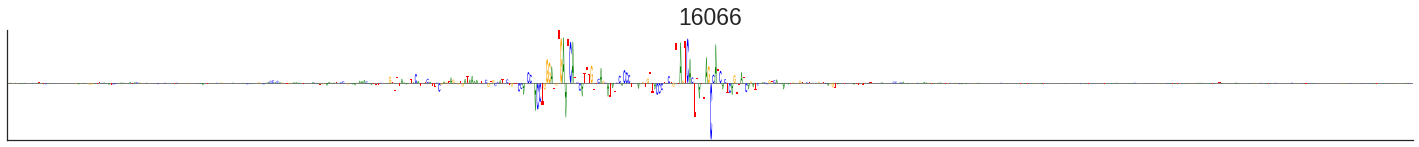

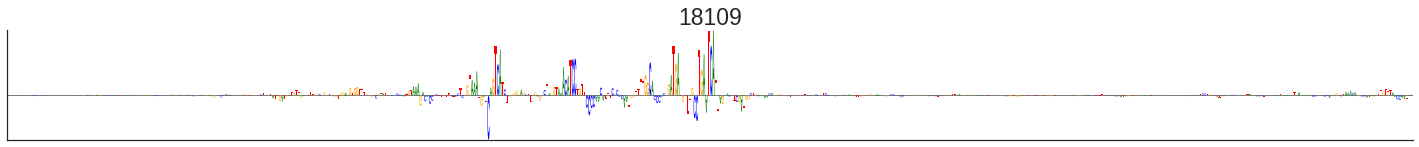

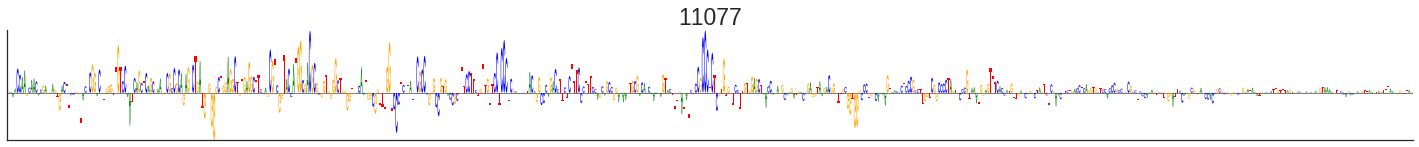

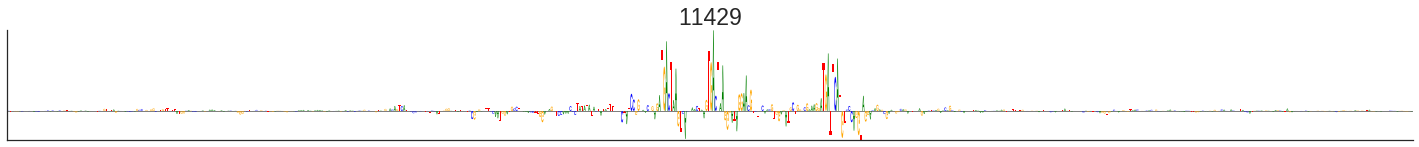

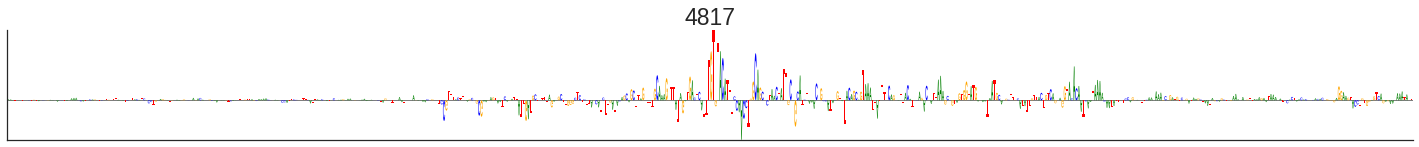

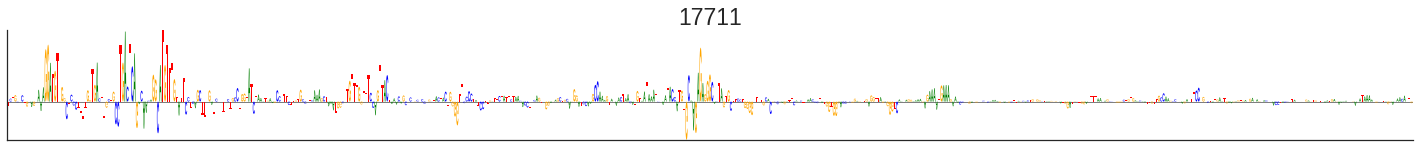

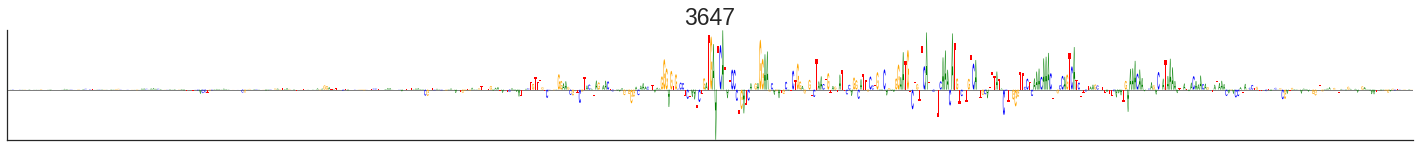

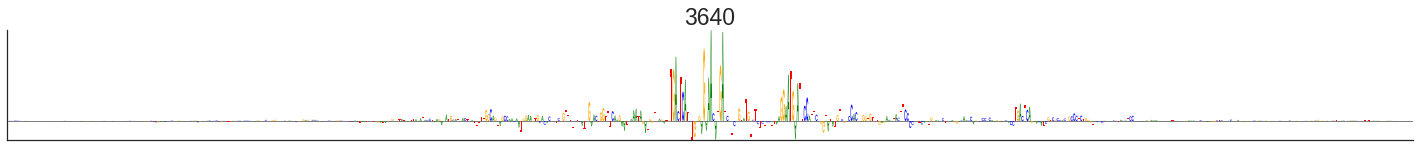

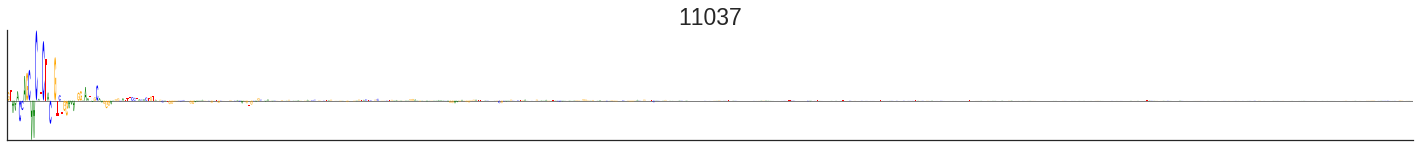

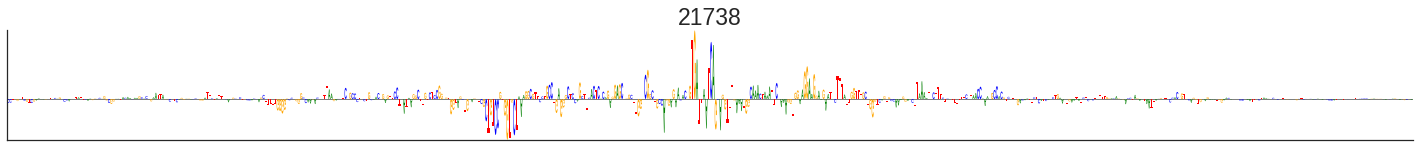

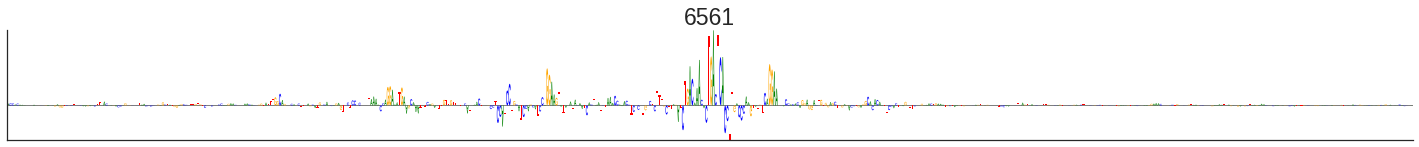

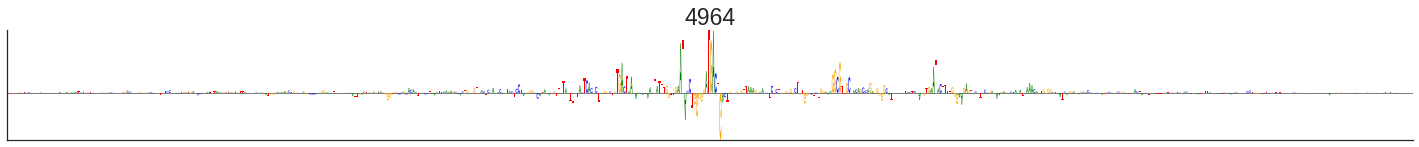

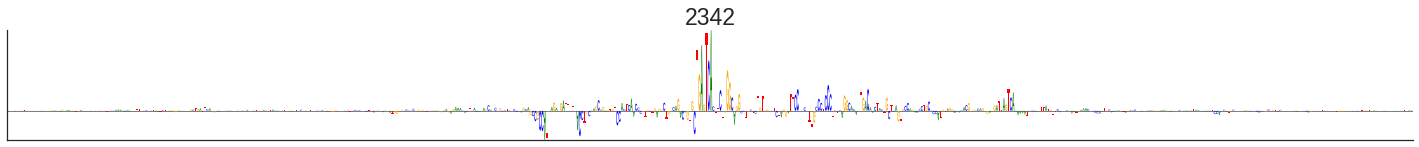

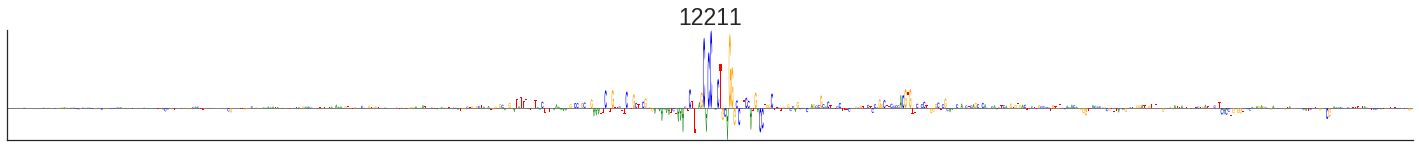

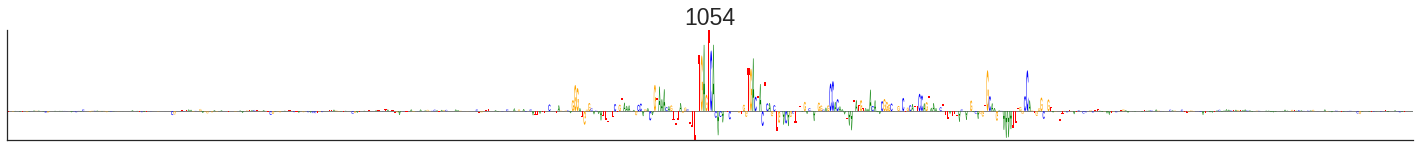

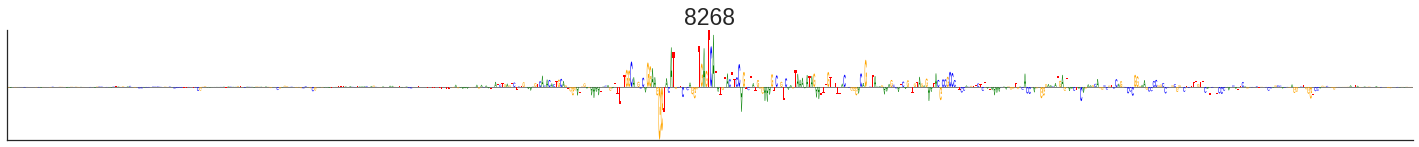

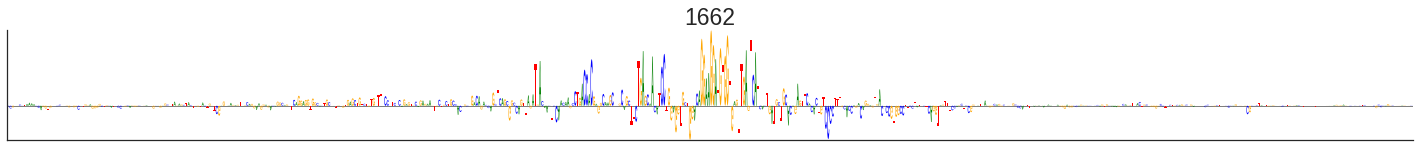

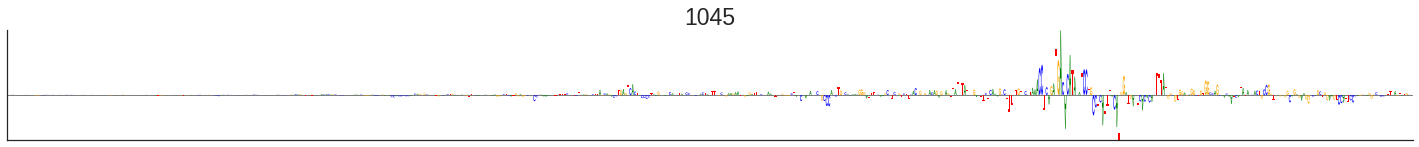

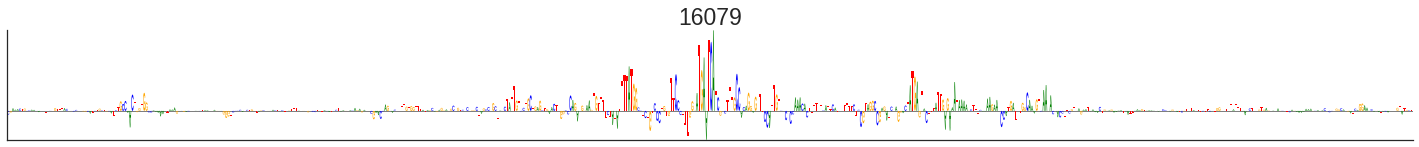

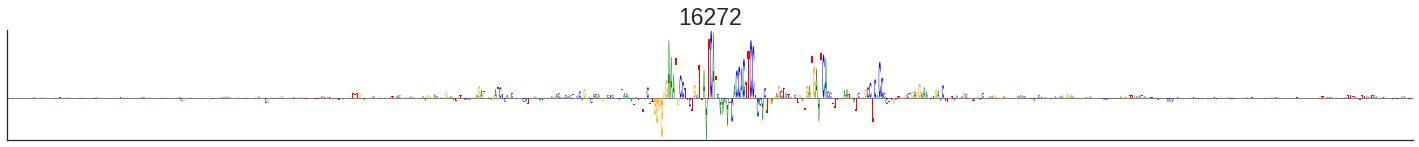

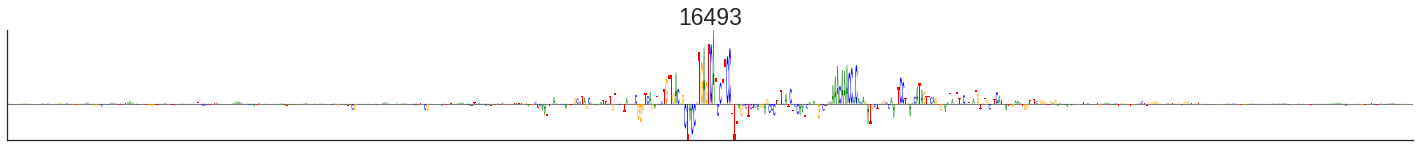

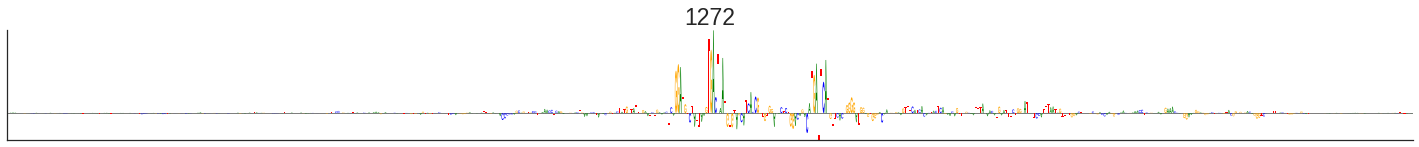

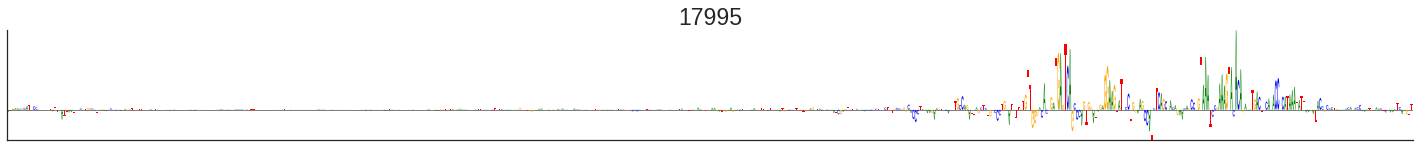

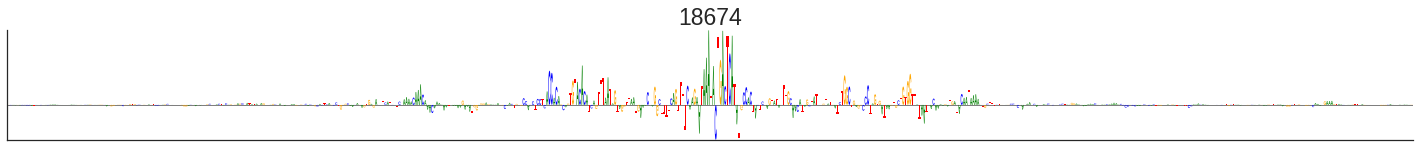

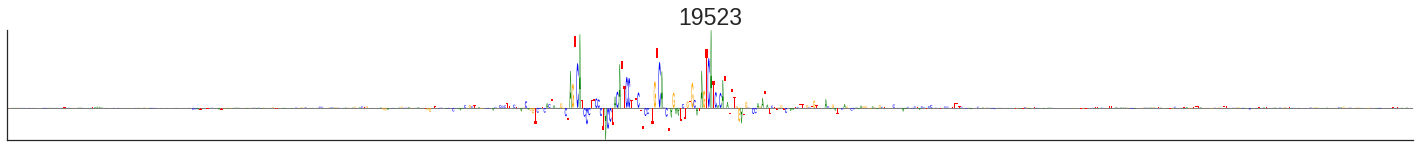

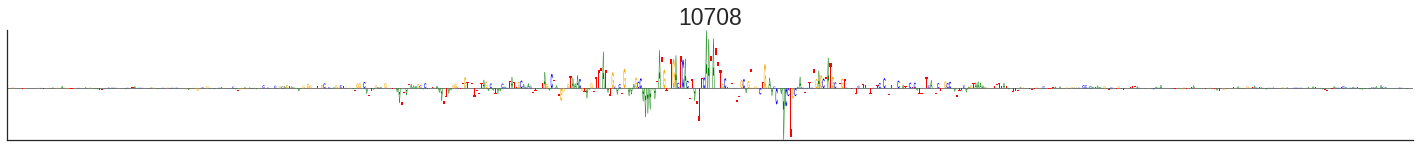

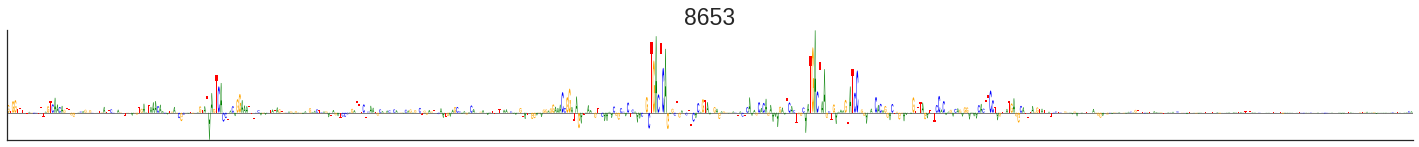

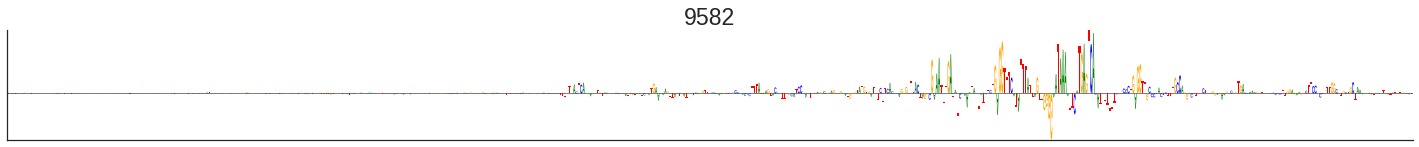

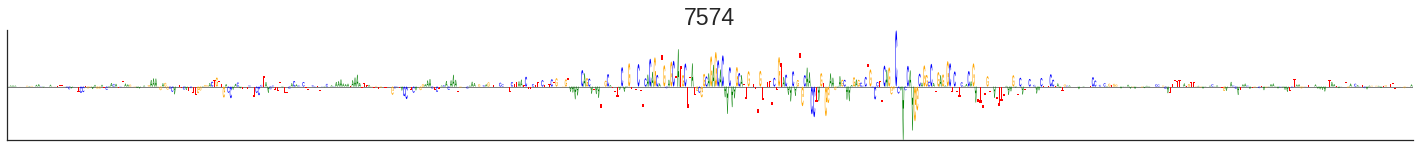

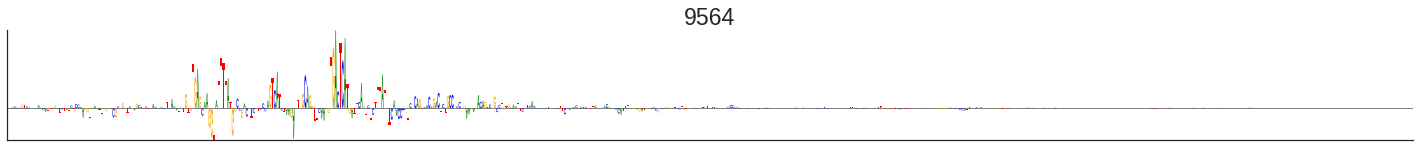

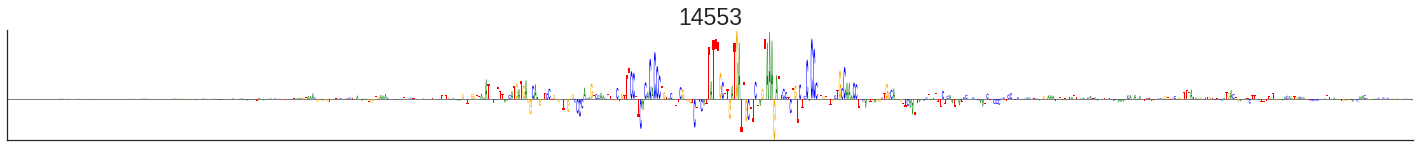

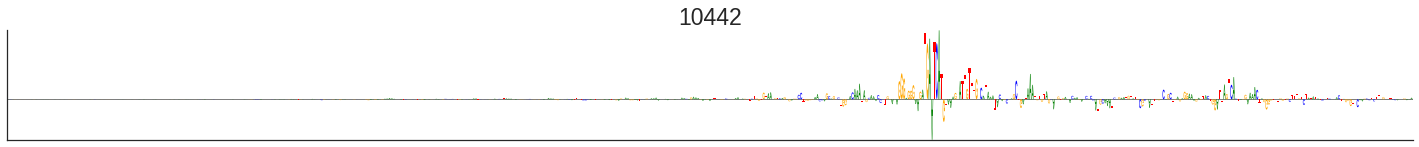

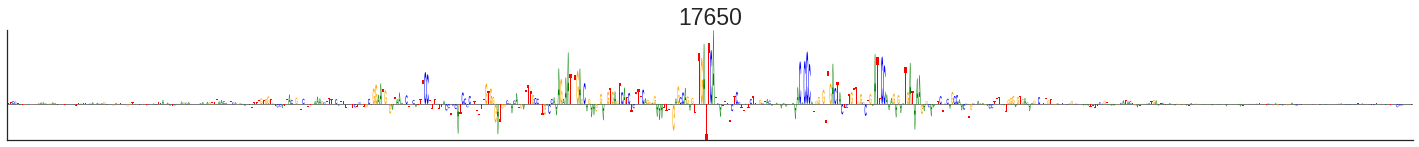

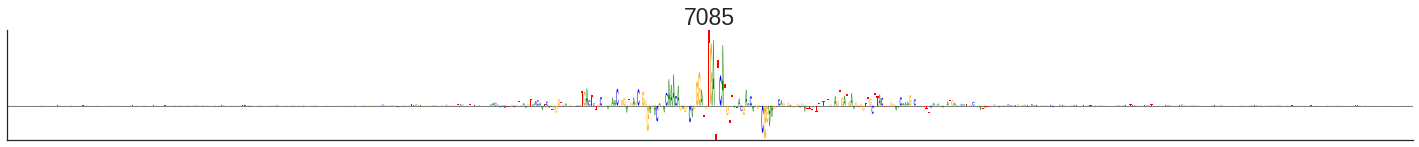

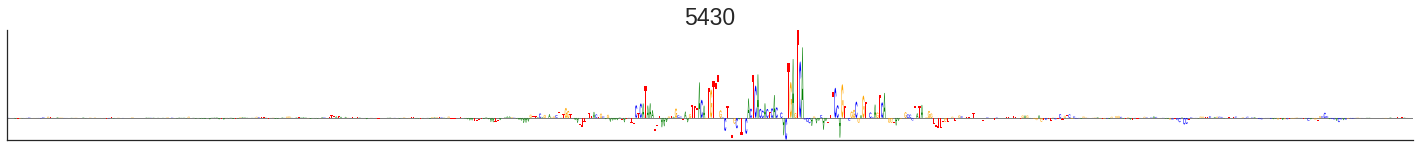

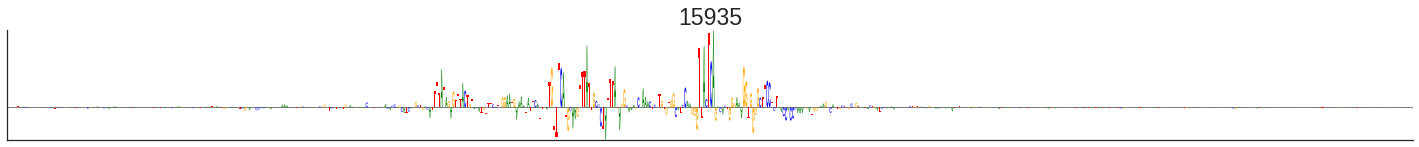

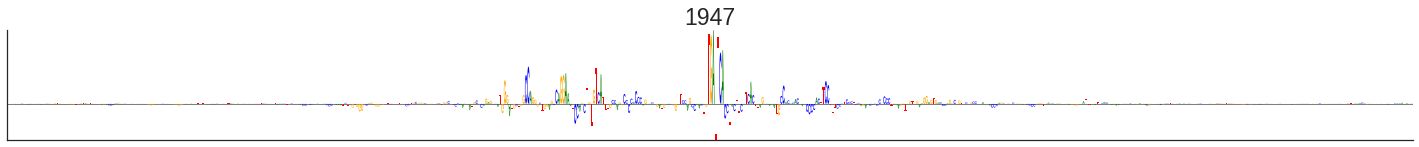

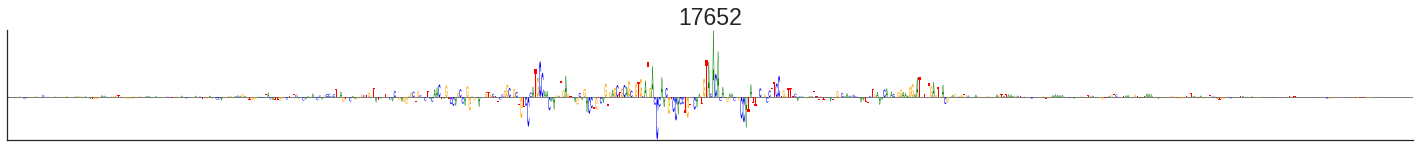

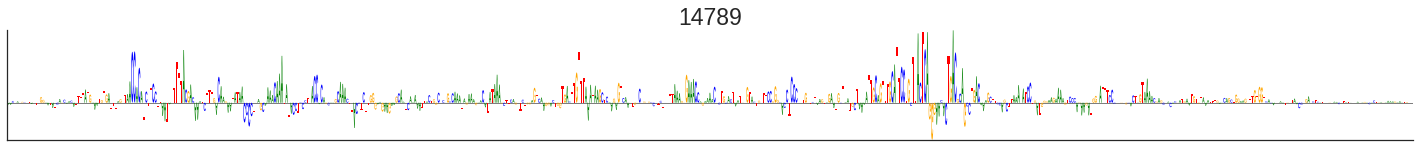

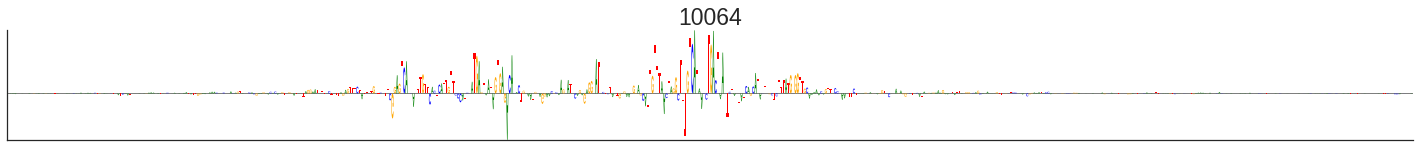

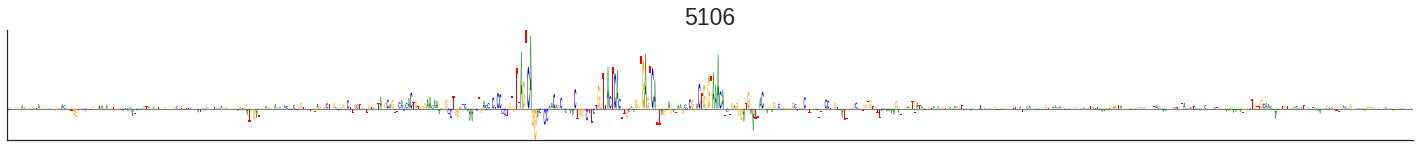

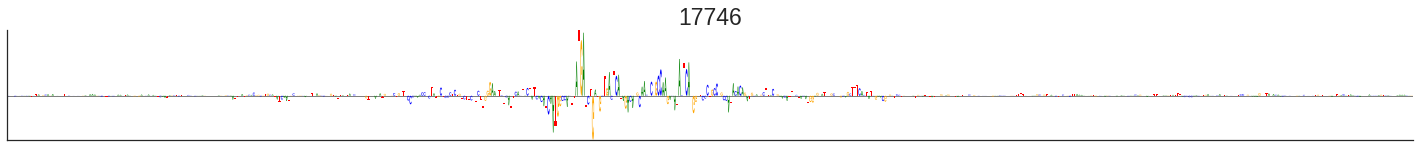

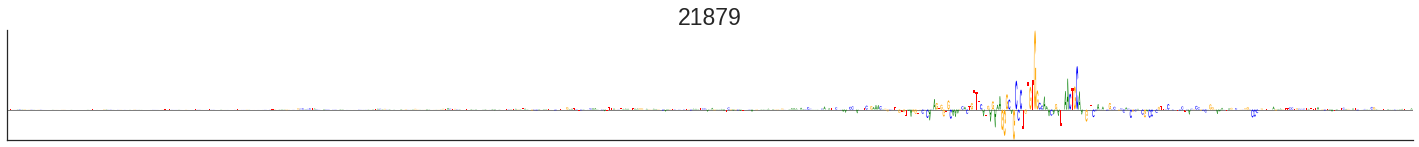

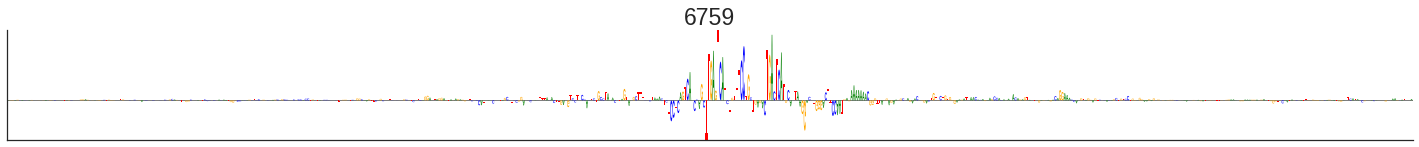

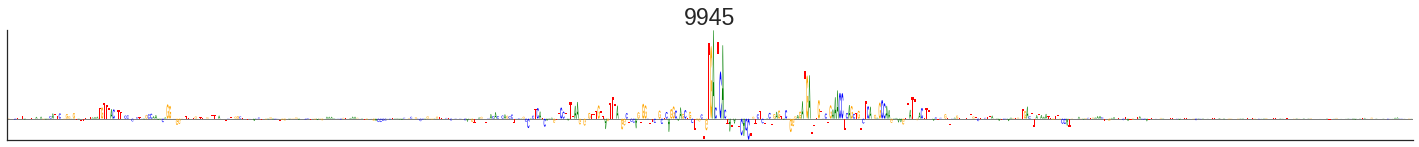

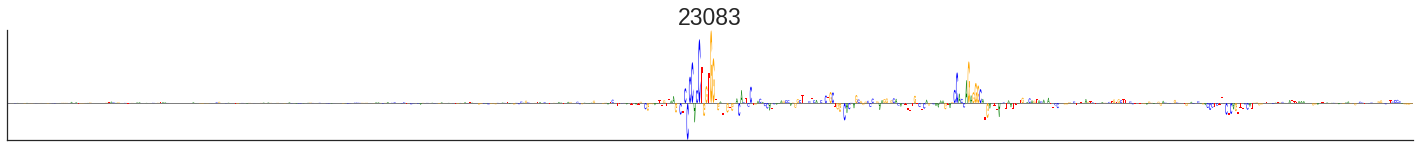

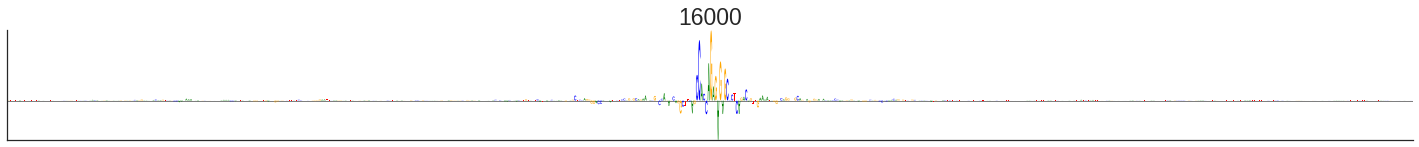

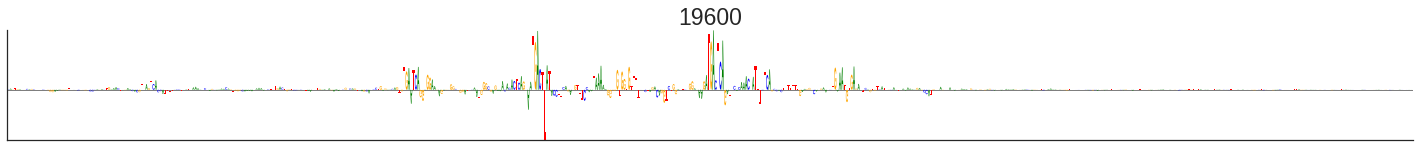

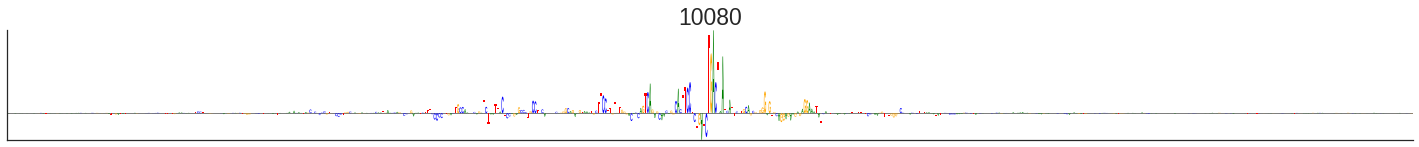

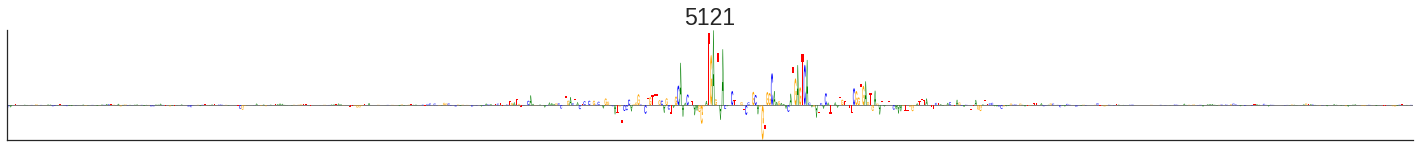

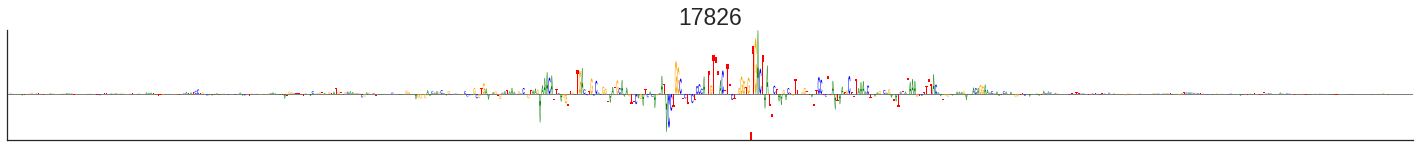

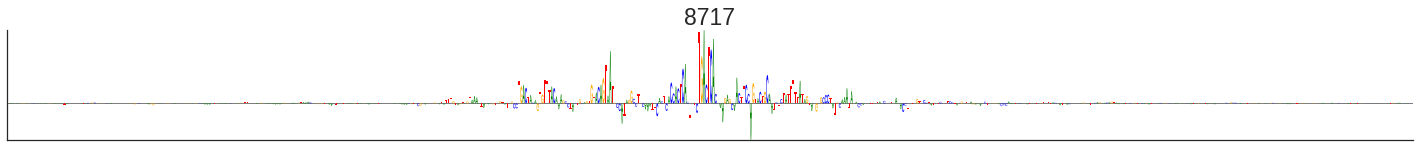

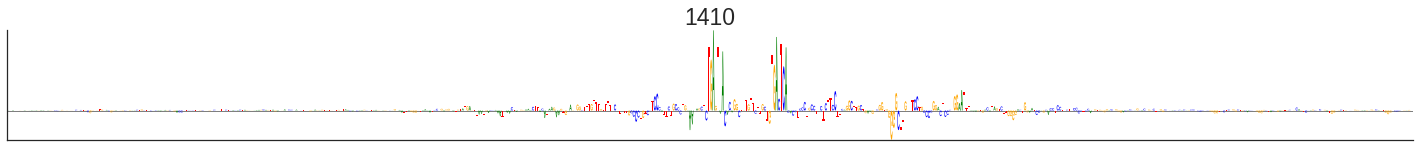

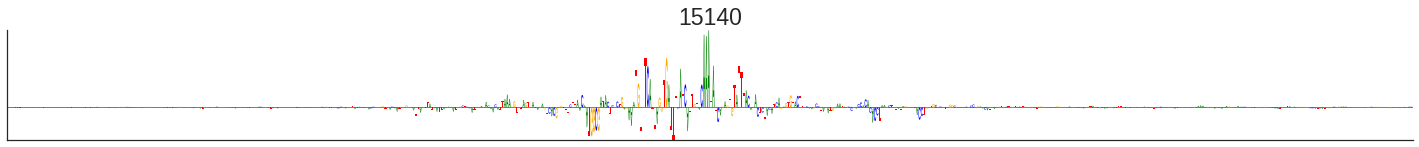

In [1202]:
# manually chose 10 indeces that have motifs at the peak - 1
for i in included_indx:
#     i = 4
#     plt.plot(thresholded_Y[included_indx[i]], label='ground truth')
#     plt.plot(np.repeat(predictions[included_indx[i], :,cell_line], bin_size), label='prediction')
#     plt.legend()
    X_sample = np.expand_dims(thresholded_X[i], axis=0)
    saliency_scores = explainer.saliency_maps(X_sample)
    # plot attribution maps in a narrow range about max saliency value
    explain.plot_saliency_logos(saliency_scores, X_sample, window=300)
    plt.title(str(i))


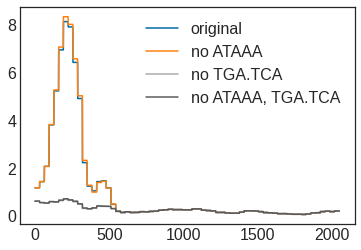

In [1203]:
i = 2177
plt.plot(np.repeat(predictions[i, :, cell_line], bin_size), label='original')
str_seq = ''.join(onehot_to_str(thresholded_X[i,:,:]))
motifs = [['ATAAA'],['TGA.TCA'],['ATAAA', 'TGA.TCA']]
all_motif_info = []
for motif_pattern in motifs:
    motif_tuples = find_motif(motif_pattern, str_seq)
    all_motif_info.append(motif_tuples)
    selected_seq = thresholded_X[i,:,:].copy()
    selected_seq, all_patterns = remove_motif_from_seq(motif_tuples, selected_seq)
    no_motif_pred = model(np.expand_dims(selected_seq, axis=0))
    plt.plot(np.repeat(no_motif_pred[0,:,cell_line], bin_size), label='no '+all_patterns)
plt.legend(bbox_to_anchor=(1,1))


In [1204]:
gc_all = get_GC_content(thresholded_X)

In [1206]:
gc_all[i]

0.42089844

In [1209]:
# select flat regions
matched_gc_indx = []
# for each sequence decide if good enough
for j in range(low_cov.shape[0]):
    pr = pearsonr(low_cov[j].reshape(2048//bin_size, bin_size).mean(axis=-1), low_pred[j,:,cell_line])[0]
    gc_i = get_GC_content(np.expand_dims(low_seqs[j], axis=0))
    delta_gc = np.abs(gc_all[i] - gc_i)
    if (low_cov[j]<2).all() and (low_pred[j,:,cell_line]<2).all() and pr>0.8 and delta_gc<0.01:
#     if (thresholded_Y[i]<5).all() and (predictions[i,:,cell_line]<5).all():
        matched_gc_indx.append(j)
#         print(j)
len(matched_gc_indx)

70

In [1210]:
motif_start, motif = all_motif_info[1][0]

In [1211]:
onehot_motif = thresholded_X[i,:,:].copy()[motif_start:motif_start+len(motif)]

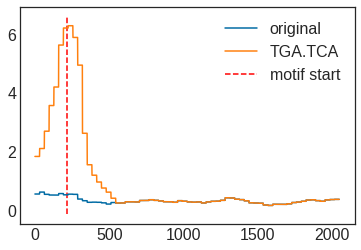

In [1212]:
low_i = 12
selected_low_seq = low_seqs[matched_gc_indx[low_i]].copy()
selected_low_seq[motif_start:motif_start+len(motif)] = onehot_motif

selected_preds = model(np.array([low_seqs[matched_gc_indx[low_i]], selected_low_seq]))

plt.plot(np.repeat(selected_preds[0,:,cell_line], bin_size), label='original')
plt.plot(np.repeat(selected_preds[1,:,cell_line], bin_size), label='TGA.TCA')
bottom, top = plt.ylim()
plt.vlines(motif_start, bottom, top, linestyle='--', color='r', label='motif start')
plt.legend()

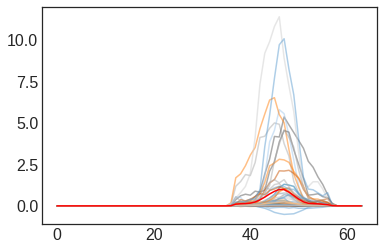

In [1165]:
motif_start = 1500
sum_diff = 0
for low_i in range(len(matched_gc_indx)):
    selected_low_seq = low_seqs[matched_gc_indx[low_i]].copy()
    selected_low_seq[motif_start:motif_start+len(motif)] = onehot_motif
    selected_preds = model(np.array([low_seqs[matched_gc_indx[low_i]], selected_low_seq]))
    diff = selected_preds[1,:,cell_line] - selected_preds[0,:,cell_line]
    plt.plot(diff, alpha=0.5)
    sum_diff += diff
plt.plot(sum_diff/len(matched_gc_indx), 'r')

In [ ]:
motif_start = 1500
sum_diff_matched = []
for low_i in range(len(matched_gc_indx)):
    selected_low_seq = low_seqs[matched_gc_indx[low_i]].copy()
    selected_low_seq[motif_start:motif_start+len(motif)] = onehot_motif
    selected_preds = model(np.array([low_seqs[matched_gc_indx[low_i]], selected_low_seq]))
    diff = selected_preds[1,:,cell_line] - selected_preds[0,:,cell_line]
   
    sum_diff_matched.append(np.sum(diff))


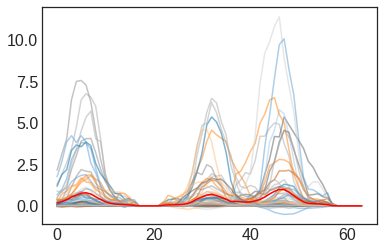

In [1166]:
motif_coords = [200, 1024, 1500]
sum_diff = 0
for low_i in range(len(matched_gc_indx)):
    selected_low_seq = low_seqs[matched_gc_indx[low_i]].copy()
    for motif_start in motif_coords:
        selected_low_seq[motif_start:motif_start+len(motif)] = onehot_motif
    selected_preds = model(np.array([low_seqs[matched_gc_indx[low_i]], selected_low_seq]))
    diff = selected_preds[1,:,cell_line] - selected_preds[0,:,cell_line]
    plt.plot(diff, alpha=0.5)
    sum_diff += diff
plt.plot(sum_diff/len(matched_gc_indx), 'r')